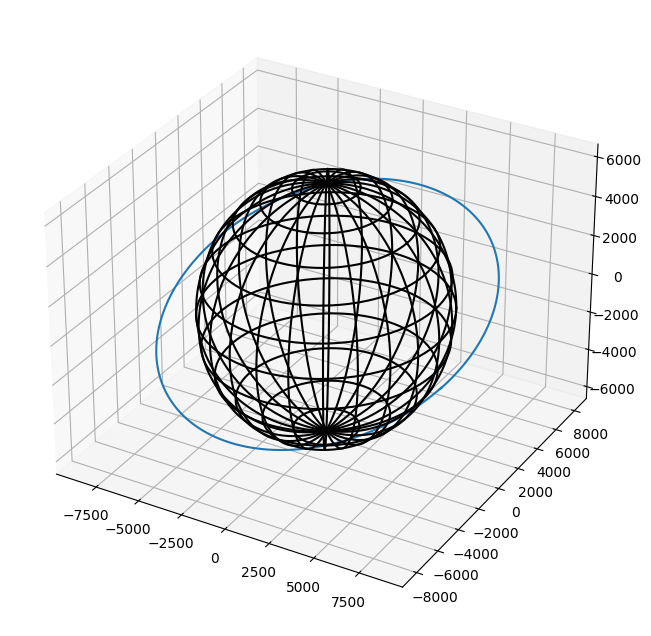

In [215]:
%run Spacecraft-Model.ipynb

In [263]:
%run ADCS-Controller.ipynb

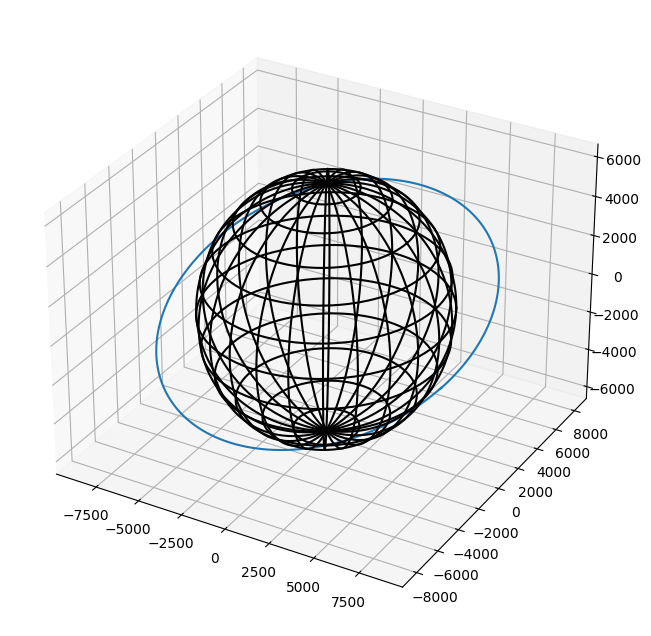

In [3]:
dt = 0.1
s1 = Spacecraft_Model(dt)
s1.graph_orbit()

Pointing


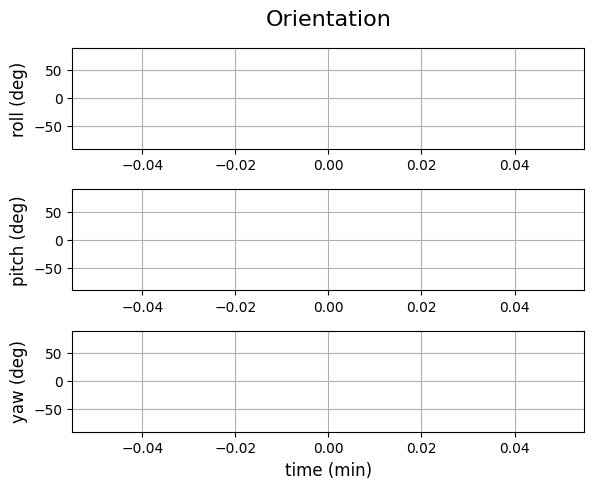

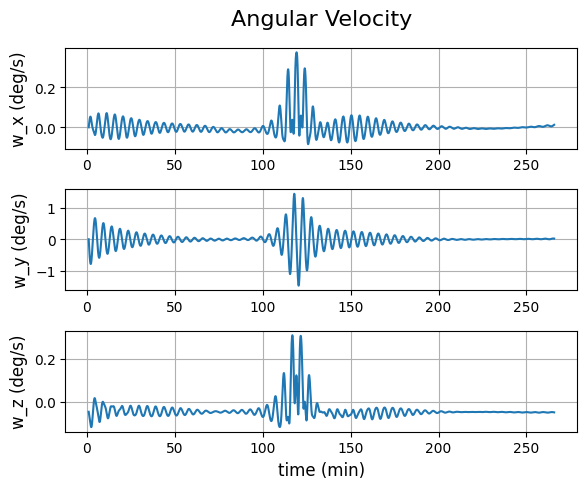

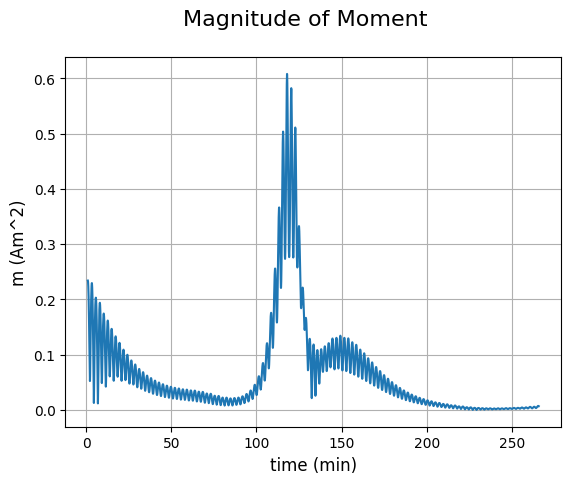

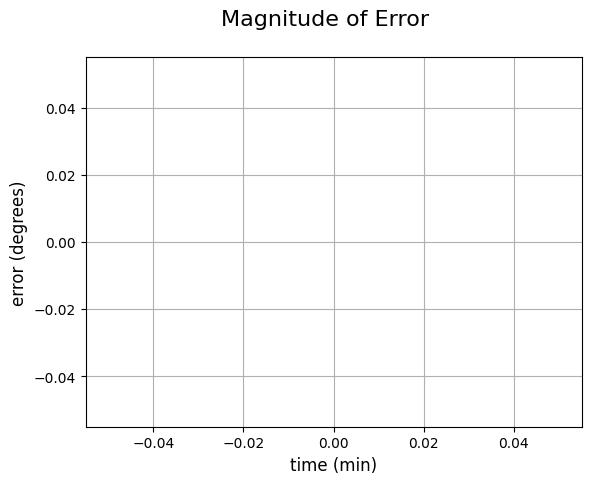

In [264]:
dt = 1
s2 = Spacecraft_Model(dt)
adcs = ADCS()
time = np.arange(0,Spacecraft_Model.orbit_len * 2,dt)

roll_history, pitch_history, yaw_history = np.zeros(len(time)), np.zeros(len(time)), np.zeros(len(time))
w_history = np.zeros((len(time), 3))
m_history = np.zeros((len(time), 1))
attitude_err_history = np.zeros((len(time), 3))

m = np.zeros(3)

tumble_start = 0
tumble_end = 0

def detumble_threshold(arr):
    return np.linalg.norm(arr) <= 10 * (np.pi / 180)
    
adcs.send("on_initialization")
under_threshold = 0
attitude_err = 0
for i in range(time.size):
    pos, cang, mag_field = s2.tick(m)
    
    # Calculate ideal orientation
    r = s2.get_position()
    v = s2.get_velocity()
    
    # Find the ideal orientation of the spacecraft in the ICRF
    b_x = -normalize(r)
    b_y = normalize(v)
    b_z = cross(b_x, b_y)

    # Construct the nominal DCM from inertial to body from the body axes
    # Compute the equilvalent quaternion
    dcm_target = np.stack([b_x, b_y, b_z])
    q_target = dcm_to_quaternion(dcm_target)

    # Calculate the difference between the desired orientation and the current orientation
    q_curr = s2.q_t
    q_err = quaternion_multiply(q_curr, quaternion_inverse(q_target))
    if under_threshold == 60:
        adcs.send('to_pointing')
        tumble_start = i
        print("Pointing")
    
    if adcs.current_state.id == 'pointing':
        adcs.point(mag_field, quaternion_to_dcm(q_target), quaternion_to_dcm(q_curr), Spacecraft_Model.w_nominal_b, s2.w_t)
        # print((i/60.0), ": ", m, mag_field, q_target, q_curr, s2.w_t)
        attitude_err = adcs.get_attitude_err(quaternion_to_dcm(q_target), quaternion_to_dcm(q_curr))
        attitude_rate_err = adcs.get_attitude_rate_err(Spacecraft_Model.w_nominal_b, s2.w_t, attitude_err)
        pointing_torque = adcs.get_pointing_torque(quaternion_to_dcm(q_target), quaternion_to_dcm(q_curr), Spacecraft_Model.w_nominal_b, s2.w_t)
        # print("t: ", round((i/60.0),2), "; Attitude Error: ", np.linalg.norm(attitude_err), "; Attitude Rate Error: ", np.linalg.norm(attitude_rate_err), "; Pointing Torque: ", np.linalg.norm(pointing_torque))

        if np.isnan(mag_field[0]):
            tumble_end = i
            break
    else:
        attiude_err = 0
        adcs.detumble(mag_field, cang)
        
    m = adcs.get_moment()
    
    yaw_history[i] = np.arctan(2*(q_err[1]*q_err[2] + q_err[0]*q_err[3]) / (q_err[3]**2 - q_err[0]**2 - q_err[1]**2 + q_err[2]**2))
    pitch_history[i] = np.arcsin(-2*(q_err[0]*q_err[2] - q_err[1]*q_err[3]))
    roll_history[i] = np.arctan(2*(q_err[0]*q_err[1] + q_err[2]*q_err[3]) / (q_err[3]**2 + q_err[0]**2 - q_err[1]**2 - q_err[2]**2))
    
    w_history[i] = s2.w_t
    m_history[i] = np.linalg.norm(m)
    attitude_err_history[i] = attitude_err
    
    if detumble_threshold(w_history[i]):
        under_threshold += 1
    # print(np.linalg.norm(w_history[i]), w_history[i][0], w_history[i][1], w_history[i][2])

time = time / 60

fig1 = plt.figure()
fig1.suptitle('Orientation', fontsize=16)

# Plot roll:
ax1 = fig1.add_subplot(3, 1, 1)
ax1.plot(time[tumble_start:tumble_end], np.rad2deg(roll_history[tumble_start:tumble_end]))
ax1.set_ylabel('roll (deg)', fontsize=12)
ax1.set(ylim=(-90,90))
ax1.grid(True)

# Plot pitch:
ax2 = fig1.add_subplot(3, 1, 2)
ax2.plot(time[tumble_start:tumble_end], np.rad2deg(pitch_history[tumble_start:tumble_end]))
ax2.set_ylabel('pitch (deg)', fontsize=12)
ax2.set(ylim=(-90,90))
ax2.grid(True)

# Plot yaw:
ax3 = fig1.add_subplot(3, 1, 3)
ax3.plot(time[tumble_start:tumble_end], np.rad2deg(yaw_history[tumble_start:tumble_end]))
ax3.set_ylabel('yaw (deg)', fontsize=12)
ax3.set_xlabel('time (min)', fontsize=12)
ax3.set(ylim=(-90,90))
ax3.grid(True)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

fig2 = plt.figure()
fig2.suptitle('Angular Velocity', fontsize=16)

# Plot rolling:
ax1 = fig2.add_subplot(3, 1, 1)
ax1.plot(time[tumble_start:tumble_end-20], np.rad2deg(w_history[tumble_start:tumble_end-20, 0]))
ax1.set_ylabel('w_x (deg/s)', fontsize=12)
ax1.grid(True)

# Plot pitching:
ax2 = fig2.add_subplot(3, 1, 2)
ax2.plot(time[tumble_start:tumble_end-20], np.rad2deg(w_history[tumble_start:tumble_end-20, 1]))
ax2.set_ylabel('w_y (deg/s)', fontsize=12)
ax2.grid(True)

# Plot yawing:
ax3 = fig2.add_subplot(3, 1, 3)
ax3.plot(time[tumble_start:tumble_end-20], np.rad2deg(w_history[tumble_start:tumble_end-20, 2]))
ax3.set_ylabel('w_z (deg/s)', fontsize=12)
ax3.set_xlabel('time (min)', fontsize=12)
ax3.grid(True)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

fig3 = plt.figure()
fig3.suptitle('Magnitude of Moment', fontsize=16)

# Plot moment:
ax1 = fig3.add_subplot(1, 1, 1)
ax1.plot(time[tumble_start:tumble_end-20], m_history[tumble_start:tumble_end-20])
ax1.set_ylabel('m (Am^2)', fontsize=12)
ax1.set_xlabel('time (min)', fontsize=12)
ax1.grid(True)

fig4 = plt.figure()
fig4.suptitle('Magnitude of Error', fontsize=16)

# Plot error:
ax1 = fig4.add_subplot(1, 1, 1)
ax1.plot(time[tumble_start:tumble_end], np.rad2deg(attitude_err_history[tumble_start:tumble_end,:]))
ax1.set_ylabel('error (degrees)', fontsize=12)
ax1.set_xlabel('time (min)', fontsize=12)
ax1.grid(True)

plt.show()

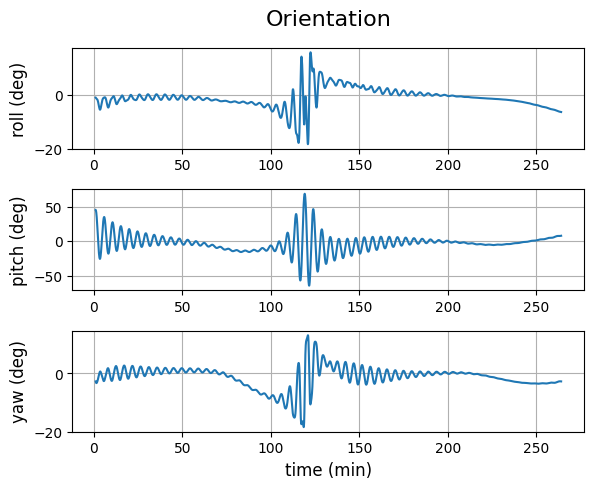

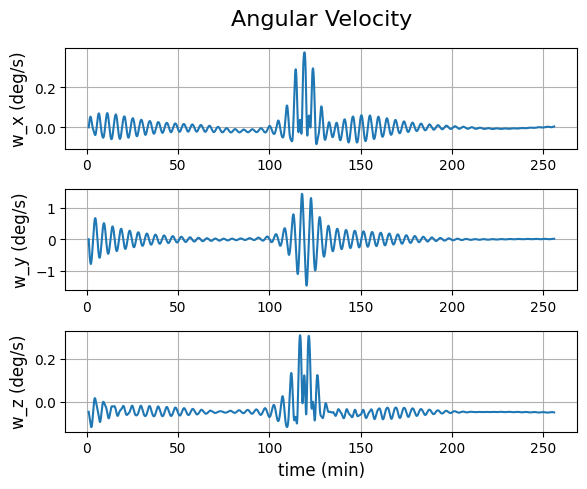

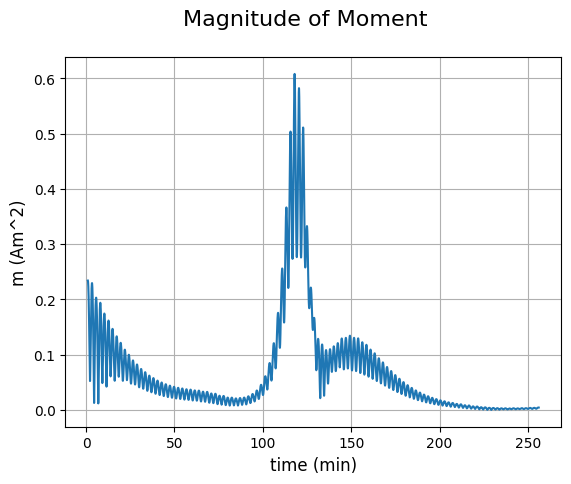

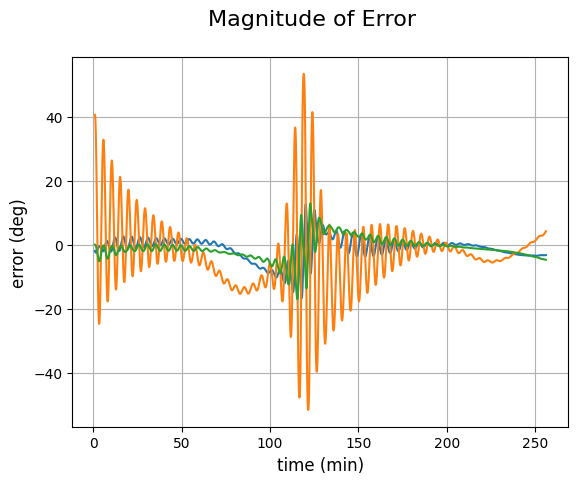

In [265]:
fig1 = plt.figure()
fig1.suptitle('Orientation', fontsize=16)

# Plot roll:
ax1 = fig1.add_subplot(3, 1, 1)
ax1.plot(time[tumble_start:tumble_end-2*60], np.rad2deg(roll_history[tumble_start:tumble_end-2*60]))
ax1.set_ylabel('roll (deg)', fontsize=12)
ax1.grid(True)

# Plot pitch:
ax2 = fig1.add_subplot(3, 1, 2)
ax2.plot(time[tumble_start:tumble_end-2*60], np.rad2deg(pitch_history[tumble_start:tumble_end-2*60]))
ax2.set_ylabel('pitch (deg)', fontsize=12)
ax2.grid(True)

# Plot yaw:
ax3 = fig1.add_subplot(3, 1, 3)
ax3.plot(time[tumble_start:tumble_end-2*60], np.rad2deg(yaw_history[tumble_start:tumble_end-2*60]))
ax3.set_ylabel('yaw (deg)', fontsize=12)
ax3.set_xlabel('time (min)', fontsize=12)
ax3.grid(True)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

fig2 = plt.figure()
fig2.suptitle('Angular Velocity', fontsize=16)

# Plot rolling:
ax1 = fig2.add_subplot(3, 1, 1)
ax1.plot(time[tumble_start:tumble_end-10*60], np.rad2deg(w_history[tumble_start:tumble_end-10*60, 0]))
ax1.set_ylabel('w_x (deg/s)', fontsize=12)
ax1.grid(True)

# Plot pitching:
ax2 = fig2.add_subplot(3, 1, 2)
ax2.plot(time[tumble_start:tumble_end-10*60], np.rad2deg(w_history[tumble_start:tumble_end-10*60, 1]))
ax2.set_ylabel('w_y (deg/s)', fontsize=12)
ax2.grid(True)

# Plot yawing:
ax3 = fig2.add_subplot(3, 1, 3)
ax3.plot(time[tumble_start:tumble_end-10*60], np.rad2deg(w_history[tumble_start:tumble_end-10*60, 2]))
ax3.set_ylabel('w_z (deg/s)', fontsize=12)
ax3.set_xlabel('time (min)', fontsize=12)
ax3.grid(True)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

fig3 = plt.figure()
fig3.suptitle('Magnitude of Moment', fontsize=16)

# Plot rolling:
ax1 = fig3.add_subplot(1, 1, 1)
ax1.plot(time[tumble_start:tumble_end-10*60], m_history[tumble_start:tumble_end-10*60])
ax1.set_ylabel('m (Am^2)', fontsize=12)
ax1.set_xlabel('time (min)', fontsize=12)
ax1.grid(True)

plt.show()


fig4 = plt.figure()
fig4.suptitle('Magnitude of Error', fontsize=16)

# Plot moment:
ax1 = fig4.add_subplot(1, 1, 1)
ax1.plot(time[tumble_start:tumble_end-10*60], np.rad2deg(attitude_err_history[tumble_start:tumble_end-10*60,:]))
ax1.set_ylabel('error (deg)', fontsize=12)
ax1.set_xlabel('time (min)', fontsize=12)
ax1.grid(True)

plt.show()

In [261]:
tumble_end

0